In [4]:
import os
import glob
import numpy as np
from logging import getLogger  
from tqdm import tqdm

In [5]:
logger = getLogger(__name__)

In [7]:
path_watnet = 'C:/Users/weverton.vitor/Documents/faculdade/pibic/fmask-pipeline/src/utils/watnet/model/pretrained/watnet.h5'

In [8]:

class imgPatch():
    '''
    author: xin luo, date: 2021.3.19
    description: 1. remote sensing image to multi-scale patches
                 2. patches to remote sensing image 
    '''
    def __init__(self, img, patch_size, edge_overlay):
        ''' edge_overlay = left overlay or, right overlay
        edge_overlay should be an even number. '''
        self.patch_size = patch_size
        self.edge_overlay = edge_overlay
        self.img = img[:,:,np.newaxis] if len(img.shape) == 2 else img
        self.img_row = img.shape[0]
        self.img_col = img.shape[1]

    def toPatch(self):
        '''
        description: convert img to patches. 
        return: 
            patch_list, contains all generated patches.
            start_list, contains all start positions(row, col) of the generated patches. 
        '''
        patch_list = []
        start_list = []
        patch_step = self.patch_size - self.edge_overlay
        img_expand = np.pad(self.img, ((self.edge_overlay, patch_step),
                                          (self.edge_overlay, patch_step), (0,0)), 'constant')
        img_patch_row = (img_expand.shape[0]-self.edge_overlay)//patch_step
        img_patch_col = (img_expand.shape[1]-self.edge_overlay)//patch_step
        for i in range(img_patch_row):
            for j in range(img_patch_col):
                patch_list.append(img_expand[i*patch_step:i*patch_step+self.patch_size,
                                                j*patch_step:j*patch_step+self.patch_size, :])
                start_list.append([i*patch_step-self.edge_overlay, j*patch_step-self.edge_overlay])
        return patch_list, start_list, img_patch_row, img_patch_col

    def higher_patch_crop(self, higher_patch_size, start_list):
        '''
        author: xin luo, date: 2021.3.19
        description: crop the higher-scale patch (centered by the given low-scale patch)
        input:
            img, np.array, the original image
            patch_size, int, the lower-scale patch size
            crop_size, int, the higher-scale patch size
            start_list, list, the start position (row,col) corresponding to the original image (generated by the toPatch function)
        return: 
            higher_patch_list, list, contains higher-scale patches corresponding to the lower-scale patches.
        '''
        higher_patch_list = []
        radius_bias = higher_patch_size//2-self.patch_size//2
        patch_step = self.patch_size - self.edge_overlay
        img_expand = np.pad(self.img, ((self.edge_overlay, patch_step), (self.edge_overlay, patch_step), (0,0)), 'constant')
        img_expand_higher = np.pad(img_expand, ((radius_bias, radius_bias), (radius_bias, radius_bias), (0,0)), 'constant')
        start_list_new = list(np.array(start_list)+self.edge_overlay+radius_bias)
        for start_i in start_list_new:
            higher_row_start, higher_col_start = start_i[0]-radius_bias, start_i[1]-radius_bias
            higher_patch = img_expand_higher[higher_row_start:higher_row_start+higher_patch_size,higher_col_start:higher_col_start+higher_patch_size,:]
            higher_patch_list.append(higher_patch)
        return higher_patch_list

    def toImage(self, patch_list, img_patch_row, img_patch_col):
        patch_list = [patch[self.edge_overlay//2:-self.edge_overlay//2, self.edge_overlay//2:-self.edge_overlay//2,:]
                                                        for patch in patch_list]
        patch_list = [np.hstack((patch_list[i*img_patch_col:i*img_patch_col+img_patch_col]))
                                                        for i in range(img_patch_row)]
        img_array = np.vstack(patch_list)
        img_array = img_array[self.edge_overlay//2:self.img_row+self.edge_overlay//2, \
            self.edge_overlay//2:self.img_col+self.edge_overlay//2,:]
        
        return img_array

In [ ]:
import tensorflow as tf
import tifffile as tiff


def watnet_infer(image_path, path_model = path_watnet):

    ''' des: surface water mapping by using pretrained watnet
        arg:
            img: np.array, surface reflectance data (!!data value: 0-1), 
                 consist of 6 bands (blue,green,red,nir,swir-1,swir-2).
            path_model: str, the path of the pretrained model.
        retrun:
            water_map: np.array.
    '''
    ###  ----- load the pretrained model -----#
    model = tf.keras.models.load_model(path_model, compile=False)
    ### ------ apply the pre-trained model
    image = tiff.imread(image_path) / 10000.0  # normalize the image data to [0, 1]
    image = image[:, :, 1:7]  # select bands Blue, Green, Red, NIR, SWIR1, SWIR2

    imgPatch_ins = imgPatch(image, patch_size=512, edge_overlay=80)
    patch_list, start_list, img_patch_row, img_patch_col = imgPatch_ins.toPatch()
    result_patch_list = [model(patch[np.newaxis, :]) for patch in patch_list]
    result_patch_list = [np.squeeze(patch, axis = 0) for patch in result_patch_list]
    pro_map = imgPatch_ins.toImage(result_patch_list, img_patch_row, img_patch_col)
    water_map = np.where(pro_map >= 0.1, 1, 0)

    

    return pro_map

In [37]:
image = watnet_infer(
    image_path="C:/Users/weverton.vitor/Documents/faculdade/pibic/fmask-pipeline/data/04_clean_images/sume_reservatorio/2022/sentinel_6B_BOA_S2_SR_sume_reservatorio_20220130_clean.tif",
    path_model=path_watnet
)



In [38]:
print(np.unique(image))  # Check unique values in the water mask
print(np.max(image))  # Check maximum value in the water mask
print(np.max(image))  # Check maximum value in the water mask

[1.8861050e-07 1.8913700e-07 2.1706347e-07 ... 9.9366611e-01 9.9375820e-01
 9.9445689e-01]
0.9944569
0.9944569


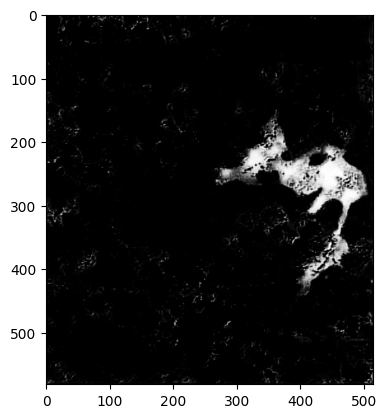

In [39]:
import matplotlib.pyplot as plt
plt.imshow(image, cmap='gray')

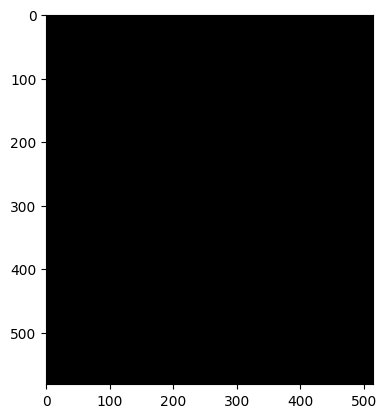

In [41]:
# ler imagem e plotar
img = 'C:/Users/weverton.vitor/Documents/faculdade/pibic/fmask-pipeline/data/07_water_masks/sume_reservatorio/2021/sentinel_6B_BOA_S2_SR_sume_reservatorio_20210115.tif'
image = tiff.imread(img)
plt.imshow(image, cmap='gray')

In [13]:
def apply_watnet(
    images_path: str,
    water_masks_save_path: str,
    location_name: str,
    skip_watnet,
    threshold,
    *args,
    **kwargs,
):
    if skip_watnet:
        logger.warning("Skip Watnet Mask processing")
        return True

    path = f"{images_path}{location_name}"
    tif_files = glob.glob(os.path.join(path, "**", "*.tif"), recursive=True)
    total_tifs = len(tif_files)

    with tqdm(
        total=total_tifs, desc="Segmenting Water in Images", unit="images"
    ) as pbar:
        for path in tif_files:
            tif_path = path.replace("\\", "/")
            watnet_infer(
               image_path=tif_path,
               save_path=f"{water_masks_save_path}{location_name}/{tif_path.split('/')[-2]}/{tif_path.split('/')[-1]}",
               threshold=threshold,
            )
            pbar.update(1)

    return True


In [ ]:
apply_watnet(
    images_path="C:/Users/weverton.vitor/Documents/faculdade/pibic/fmask-pipeline/src/data/images/",
    water_masks_save_path="C:/Users/weverton.vitor/Documents/faculdade/pibic/fmask-pipeline/src/data/water_masks/",
    location_name="example_location",
    skip_watnet=False,
    threshold=0.5,
)

<function __main__.apply_watnet(images_path: str, water_masks_save_path: str, location_name: str, skip_watnet, threshold, *args, **kwargs)>